# Project Goal

Prevent massive runs on funds by predicting fund purchase and redemption

# Project Overview

https://tianchi.aliyun.com/competition/entrance/231573/information

**Dataset Overview**

4 tables: user_profile_table, user_balance_table, mfd_day_share_interest, mfd_bank_shibor

28k customer，2840k behaviour data，294-day Shibor (Shanghai Interbank Offered Rate)，427-day yield

Time range: 
2013-07-01 ~ 2014-08-31

Predict:
The purchase and redemption from 2014-09-01 ~ 2014-09-30


**Tables Overview：**

- 用户信息表 user_profile_table

- 用户申购赎回数据 user_balance_table

金额的单位是分，即0.01元

如果用户今日消费总量为0，即consume_amt=0，同时四个category字段为空

数据经过了脱敏，同时保证了：
今日余额 = 昨日余额 + 今日申购 - 今日赎回，不会出现负值

- 收益率表 mfd_day_share_interest

- 上海银行间同业拆放利率表 mfd_bank_shibor

**收益计算方式：**

主要基于实际余额宝收益计算方法，进行了简化：

1）收益计算的时间不再是会计日，而是自然日，以0点为分隔（0点之前算昨天，0点之后算今天）

2）收益的显示时间，即实际将第一份收益打入用户账户的时间，以周一转入周三显示为例，如果用户在周一存入10000元，即1000000分，那么这笔金额是周一确认，周二是开始产生收益，在周三将周二产生的收益打入到用户的账户中，此时用户的账户中显示的是1000110分


**提交结果格式：**

每一行数据是report_date, purchase, redeem，即一天对申购、赎回总额的预测值，输出2014年9月每天的预测，共30行。 

purchase 和 redeem 都是金额数据，精确到分


**评估指标：**

申购、赎回各自的相对误差。

误差与得分之间的计算公式不公布，但保证单调递减第 i 天的申购误差Purchase_i=0 ，这一天的得分为10分；当Purchase_i > 0.3，得分为0。

总积分 = 申购预测得分*45% + 赎回预测得分*55%

申购和赎回每天总分=10，9月30天，因此 **总分 = 300分**。


In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller


from fbprophet import Prophet

import warnings
warnings.filterwarnings('ignore')

# Load Data

In [109]:
data = pd.read_csv('data/user_balance_table.csv', parse_dates = ['report_date'])
data.head()

,user_id,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
0,1,2014-08-05,20385,20383,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
1,1,2014-08-08,20391,20389,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
2,1,2014-08-11,20397,20395,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
3,1,2014-08-14,20403,20401,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
4,1,2014-08-17,20409,20407,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN


In [167]:
print(data.isnull().sum())

user_id                      0
report_date                  0
tBalance                     0
yBalance                     0
total_purchase_amt           0
direct_purchase_amt          0
purchase_bal_amt             0
purchase_bank_amt            0
total_redeem_amt             0
consume_amt                  0
transfer_amt                 0
tftobal_amt                  0
tftocard_amt                 0
share_amt                    0
category1              2666682
category2              2666682
category3              2666682
category4              2666682
dtype: int64


In [168]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2840421 entries, 0 to 2840420
Data columns (total 18 columns):
 #   Column               Dtype         
---  ------               -----         
 0   user_id              int64         
 1   report_date          datetime64[ns]
 2   tBalance             int64         
 3   yBalance             int64         
 4   total_purchase_amt   int64         
 5   direct_purchase_amt  int64         
 6   purchase_bal_amt     int64         
 7   purchase_bank_amt    int64         
 8   total_redeem_amt     int64         
 9   consume_amt          int64         
 10  transfer_amt         int64         
 11  tftobal_amt          int64         
 12  tftocard_amt         int64         
 13  share_amt            int64         
 14  category1            float64       
 15  category2            float64       
 16  category3            float64       
 17  category4            float64       
dtypes: datetime64[ns](1), float64(4), int64(13)
memory usage: 390.

In [111]:
data['report_date'].nunique()

427

### Thought:

since data['report_date'].nunique() < data.shape[0], we need to aggregate y (y1: 'total_purchase_amt', y2: 'total_redeem_amt') by grouping 'report_date'

# Data Process

## sum purchase & redeem over each 'report_date'

In [112]:
df = data.groupby(['report_date'])[['total_purchase_amt', 'total_redeem_amt']].sum()
df.head()

,total_purchase_amt,total_redeem_amt
report_date,,
2013-07-01,32488348,5525022
2013-07-02,29037390,2554548
2013-07-03,27270770,5953867
2013-07-04,18321185,6410729
2013-07-05,11648749,2763587


In [113]:
purchase = df[['total_purchase_amt']]

redeem = df[['total_redeem_amt']]

purchase.tail()

,total_purchase_amt
report_date,
2014-08-27,302194801
2014-08-28,245082751
2014-08-29,267554713
2014-08-30,199708772
2014-08-31,275090213


In [114]:
# save python object, and loading is 10 times faster than raw data loading

# purchase.to_pickle('./data/purchase.pkl')
# redeem.to_pickle('./data/redeem.pkl')

# Time Series Visualisation for Purchase & Redemption 

## seasonal_decompose

In [58]:
# 对于指定时间范围的data进行可视化
def plot_stl(data):
    result = sm.tsa.seasonal_decompose(data, period = 30)
    
    # trend, seasonal, residual
    fig = plt.figure(figsize = (12,8))
    ax1 = fig.add_subplot(3,1,1)
    ax2 = fig.add_subplot(3,1,2)
    ax3 = fig.add_subplot(3,1,3)
    
    result.trend.plot(ax=ax1, title="Trend")
    result.seasonal.plot(ax=ax2, title="Seasonal")
    result.resid.plot(ax=ax3, title="Residual")
    

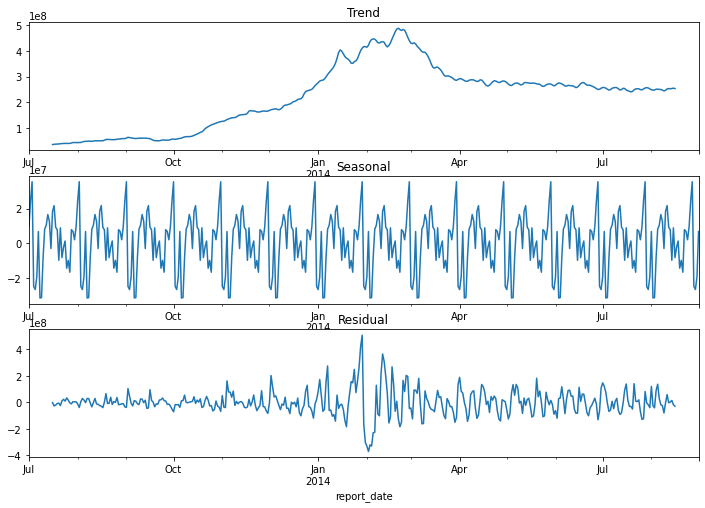

In [59]:
plot_stl(purchase)

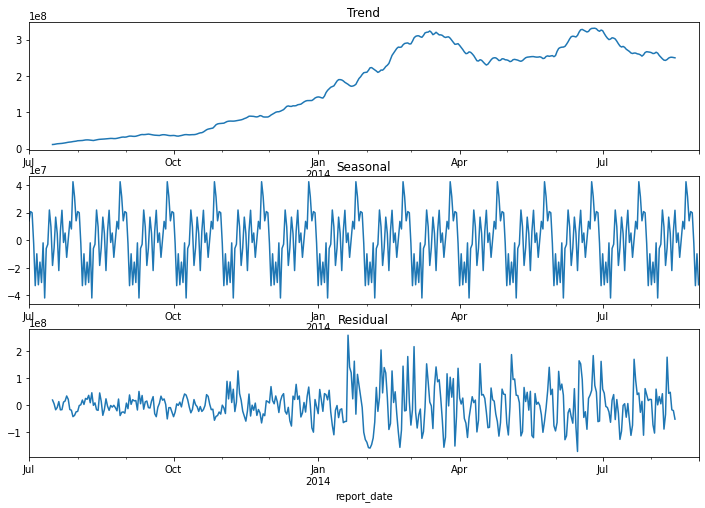

In [60]:
plot_stl(redeem)

# Simple Model Prediction (only use report_date, purchase, redemption)

# 1. Baseline: ARIMA

## AdFuller Test for Analysing the Stationary of Series

- 平稳性检测（ADF检测）:

在使用时间序列模型时（比如 ARMA、ARIMA），需要时间序列是平稳的，所以第一步都需要进行平稳性检验。

常用的统计检验方法为ADF检验（也称为单位根检验）。

ADF检验，就是判断序列是否存在单位根，如果序列平稳，就不存在单位根，否则，就会存在单位根。

- ADF检验的 **${H_0}$ 假设**:

存在单位根 or **数据不平稳**。

如果得到的显著性检验统计量小于三个置信度（10\%，5\%，1\%），则对应有（90\%，95\%，99\%）的把握来拒绝原假设。



In [116]:
with open('./data/purchase.pkl', 'rb') as file:
    purchase = pickle.load(file)

with open('./data/redeem.pkl', 'rb') as file:
    redeem = pickle.load(file)

## fit purchase: ARIMA d=1

In [61]:
# sometimes you need a bit convertion: adfuller(df.iloc[:,0].values)
t = adfuller(purchase)
t

# t = -1.58988 > 10% p-value，H0 can't be rejected

(-1.5898802926313507,
 0.4886749751375928,
 18,
 408,
 {'1%': -3.446479704252724,
  '5%': -2.8686500930967354,
  '10%': -2.5705574627547096},
 15960.28197033403)

In [62]:
diff1 = purchase.diff(1)
diff1

,total_purchase_amt
report_date,
2013-07-01,NaN
2013-07-02,-3450958.0
2013-07-03,-1766620.0
2013-07-04,-8949585.0
2013-07-05,-6672436.0
...,...
2014-08-27,-4750288.0
2014-08-28,-57112050.0
2014-08-29,22471962.0


In [63]:
t = adfuller(diff1[1:])
t

# t = -7.94710 < 1% p-value，H0 is rejected

(-7.947102224652354,
 3.1981868624879897e-12,
 18,
 407,
 {'1%': -3.4465195891135845,
  '5%': -2.8686676281678634,
  '10%': -2.5705668101226085},
 15918.844657651942)

### Thought:

For purchase, d = 1 (takes difference 1 time), now the time series is stationary.

<AxesSubplot:xlabel='report_date'>

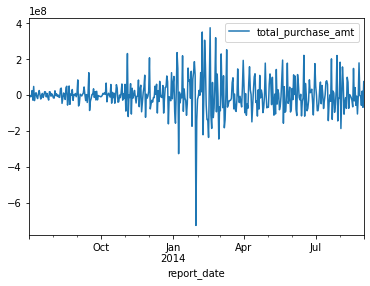

In [64]:
diff1[1:].plot()

In [117]:
model = ARIMA(purchase,order=(7,1,5)).fit()

# typ = 'levels': 反差分，不加则结果是平稳序列下的结果
purchase_pred = model.predict('2014-09-01', '2014-09-30', typ = 'levels')

purchase_pred

2014-09-01    3.310521e+08
2014-09-02    3.318773e+08
2014-09-03    3.338918e+08
2014-09-04    2.983190e+08
2014-09-05    2.407522e+08
2014-09-06    2.266125e+08
2014-09-07    2.435553e+08
2014-09-08    2.970862e+08
2014-09-09    3.321273e+08
2014-09-10    3.265214e+08
2014-09-11    2.916840e+08
2014-09-12    2.392709e+08
2014-09-13    2.253541e+08
2014-09-14    2.475277e+08
2014-09-15    2.950938e+08
2014-09-16    3.345007e+08
2014-09-17    3.280834e+08
2014-09-18    2.927105e+08
2014-09-19    2.448967e+08
2014-09-20    2.275707e+08
2014-09-21    2.530214e+08
2014-09-22    2.980719e+08
2014-09-23    3.366749e+08
2014-09-24    3.321960e+08
2014-09-25    2.947118e+08
2014-09-26    2.505380e+08
2014-09-27    2.318264e+08
2014-09-28    2.574456e+08
2014-09-29    3.025698e+08
2014-09-30    3.387025e+08
Freq: D, dtype: float64

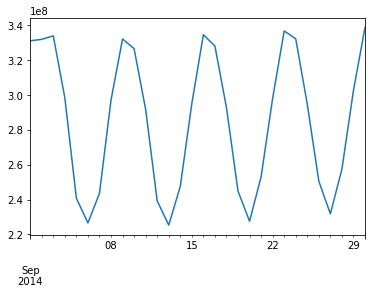

In [66]:
purchase_pred.plot()
plt.show()

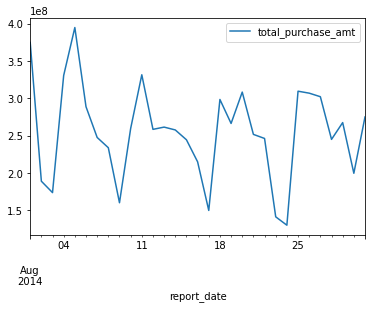

In [67]:
# compare with last month
purchase[(purchase.index >= '2014-08-01') & (purchase.index <= '2014-08-31')].plot()
plt.show()

## fit redeem: ARIMA d=1

In [68]:
t = adfuller(redeem)
t

(-1.3724136798283428,
 0.5954275877949456,
 13,
 413,
 {'1%': -3.4462831955497135,
  '5%': -2.8685636962704395,
  '10%': -2.5705114078759914},
 15816.780952766481)

In [69]:
diff1 = redeem.diff(1)

t = adfuller(diff1[1:])
t

(-11.69198690696882,
 1.6443717458499181e-21,
 12,
 413,
 {'1%': -3.4462831955497135,
  '5%': -2.8685636962704395,
  '10%': -2.5705114078759914},
 15779.04993673871)

差分了1次，通过了平稳性检验。

<AxesSubplot:xlabel='report_date'>

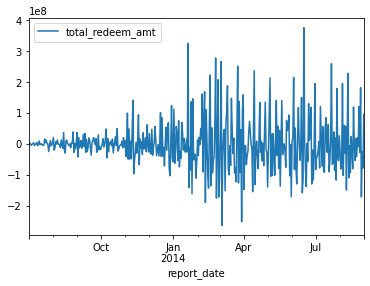

In [70]:
diff1[1:].plot()

In [118]:
model2 = ARIMA(redeem, order=(7,1,5)).fit()

# typ='levels': 反差分
redeem_pred = model2.predict('2014-09-01', '2014-09-30', typ='levels')

redeem_pred

2014-09-01    3.169075e+08
2014-09-02    3.372505e+08
2014-09-03    3.632469e+08
2014-09-04    3.074799e+08
2014-09-05    2.628073e+08
2014-09-06    2.258814e+08
2014-09-07    2.592213e+08
2014-09-08    3.115544e+08
2014-09-09    3.477534e+08
2014-09-10    3.562478e+08
2014-09-11    3.092846e+08
2014-09-12    2.598568e+08
2014-09-13    2.339211e+08
2014-09-14    2.578268e+08
2014-09-15    3.125563e+08
2014-09-16    3.537340e+08
2014-09-17    3.573688e+08
2014-09-18    3.146285e+08
2014-09-19    2.626671e+08
2014-09-20    2.387526e+08
2014-09-21    2.616259e+08
2014-09-22    3.157237e+08
2014-09-23    3.588209e+08
2014-09-24    3.611614e+08
2014-09-25    3.198025e+08
2014-09-26    2.672118e+08
2014-09-27    2.432922e+08
2014-09-28    2.661254e+08
2014-09-29    3.197189e+08
2014-09-30    3.635570e+08
Freq: D, dtype: float64

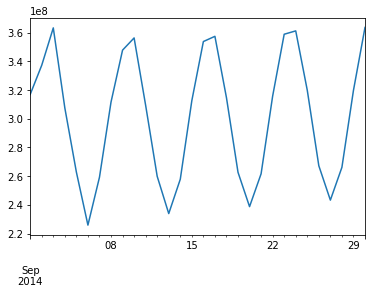

In [72]:
redeem_pred.plot()
plt.show()

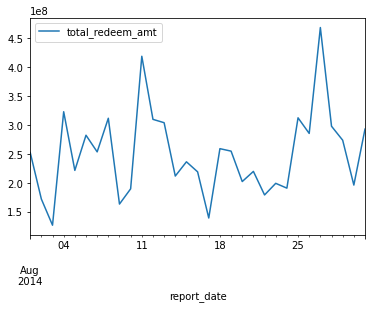

In [73]:
# compare with last month
redeem[(redeem.index >= '2014-08-01') & (redeem.index <= '2014-08-31')].plot()
plt.show()

## combine purchase prediction & redeem prediction

In [119]:
result1 = pd.DataFrame()
result1['report_date'] = purchase_pred.index
result1['purchase'] = purchase_pred.values
result1['redeem'] = redeem_pred.values

result1['report_date'] = result1['report_date'].apply(lambda x: str(x).replace('-','')[0:8])

result1.head()

,report_date,purchase,redeem
0,20140901,3.310521e+08,3.169075e+08
1,20140902,3.318773e+08,3.372505e+08
2,20140903,3.338918e+08,3.632469e+08
3,20140904,2.983190e+08,3.074799e+08
4,20140905,2.407522e+08,2.628073e+08


In [ ]:
# result1.to_csv('baseline_arima.csv', header=None, index=False)

## => ARIMA(7,1,5): online score = 101.2314

Disadvantages of ARIMA:

1) it is autoregressive, meanning estimate based on previous days, but there might be a weekly pattern

2) it didn't take holidays, events (e.g. interest rate change) into account


选择特征：

可以用简单的统计量来作为特征，从中提取出有用的信息：

1) 中位数：居于中间位置的数，较为稳健

2) 均值：当分布符合正态分布时，可以代表整体特征

3) 临近数据：离待测数据越近的数据对其影响越大

# 2. Prophet

In [76]:
from fbprophet import Prophet
import pickle

In [77]:
with open('./data/purchase.pkl', 'rb') as file:
    purchase = pickle.load(file)

with open('./data/redeem.pkl', 'rb') as file:
    redeem = pickle.load(file)

purchase = purchase.reset_index()
purchase.columns = ['ds', 'y']

redeem = redeem.reset_index()
redeem.columns = ['ds', 'y']

## fit purchase

In [78]:
model = Prophet(yearly_seasonality = True, seasonality_prior_scale = 0.1)

model.fit(purchase)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [79]:
future = model.make_future_dataframe(periods = 30)
future.tail(10)

,ds
447,2014-09-21
448,2014-09-22
449,2014-09-23
450,2014-09-24
451,2014-09-25
452,2014-09-26
453,2014-09-27
454,2014-09-28
455,2014-09-29
456,2014-09-30


In [80]:
# predict next 30 days in 09-2014

purchase_pred = model.predict(future)
purchase_pred.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-07-01,1.045382e+08,-2.699601e+07,1.811361e+08,1.045382e+08,1.045382e+08,-2.516037e+07,-2.516037e+07,-2.516037e+07,4.494683e+07,4.494683e+07,4.494683e+07,-7.010720e+07,-7.010720e+07,-7.010720e+07,0.0,0.0,0.0,7.937780e+07
1,2013-07-02,1.051208e+08,-2.140275e+07,1.800369e+08,1.051208e+08,1.051208e+08,-2.499085e+07,-2.499085e+07,-2.499085e+07,4.767347e+07,4.767347e+07,4.767347e+07,-7.266432e+07,-7.266432e+07,-7.266432e+07,0.0,0.0,0.0,8.012993e+07
2,2013-07-03,1.057034e+08,-3.999394e+07,1.693381e+08,1.057034e+08,1.057034e+08,-3.725546e+07,-3.725546e+07,-3.725546e+07,3.774492e+07,3.774492e+07,3.774492e+07,-7.500038e+07,-7.500038e+07,-7.500038e+07,0.0,0.0,0.0,6.844793e+07
3,2013-07-04,1.062860e+08,-5.196742e+07,1.474926e+08,1.062860e+08,1.062860e+08,-5.755977e+07,-5.755977e+07,-5.755977e+07,1.952314e+07,1.952314e+07,1.952314e+07,-7.708291e+07,-7.708291e+07,-7.708291e+07,0.0,0.0,0.0,4.872623e+07
4,2013-07-05,1.068686e+08,-9.216931e+07,1.060726e+08,1.068686e+08,1.068686e+08,-9.679845e+07,-9.679845e+07,-9.679845e+07,-1.791228e+07,-1.791228e+07,-1.791228e+07,-7.888617e+07,-7.888617e+07,-7.888617e+07,0.0,0.0,0.0,1.007016e+07


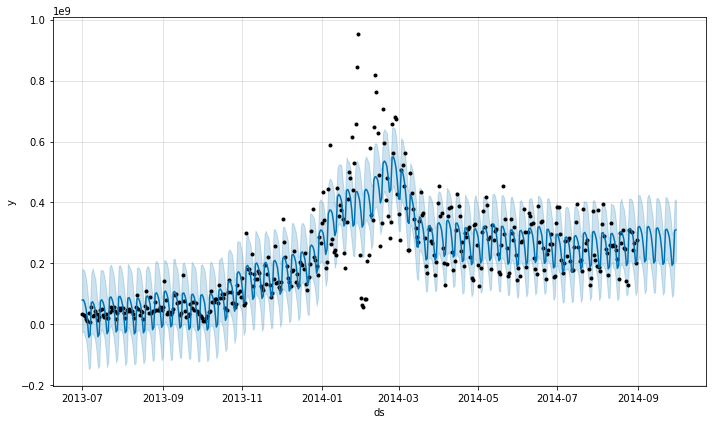

In [81]:
model.plot(purchase_pred)
plt.show()

In [82]:
purchase2 = purchase_pred[purchase_pred['ds']>='2014-09-01'][['ds', 'yhat']]

## fit redeem

In [83]:
model2 = Prophet(yearly_seasonality = True, seasonality_prior_scale = 0.1)
model2.fit(redeem)

future2 = model2.make_future_dataframe(periods = 30)
redeem_pred = model.predict(future2)
redeem2 = redeem_pred[redeem_pred['ds']>='2014-09-01'][['ds', 'yhat']]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## combine purchase prediction & redeem prediction

In [105]:
result2 = pd.DataFrame()
result2['report_date'] = purchase2.ds
result2['purchase'] = purchase2.yhat
result2['redeem'] = redeem2.yhat

result2['report_date'] = result['report_date'].apply(lambda x: str(x).replace('-','')[0:8])

result2.head()

,report_date,purchase,redeem
427,20140901,3.181871e+08,3.181871e+08
428,20140902,3.214351e+08,3.214351e+08
429,20140903,3.118692e+08,3.118692e+08
430,20140904,2.938550e+08,2.938550e+08
431,20140905,2.564788e+08,2.564788e+08


In [ ]:
# result2.to_csv('baseline_prophet.csv', header=None, index=False)

## => Prophet: online score = 100.1324

# 3. Model stacking

In [158]:
arima_result = pd.DataFrame(result1.values, columns=['ds', 'purchase1', 'redeem1'])
prophet_result = pd.DataFrame(result2.values, columns=['ds', 'purchase2', 'redeem2'])

In [159]:
df = arima_result.merge(prophet_result, on='ds', how='left')
df.head()

,ds,purchase1,redeem1,purchase2,redeem2
0,20140901,331052148.944308,316907458.896058,318187058.519883,318187058.519883
1,20140902,331877345.777803,337250518.268437,321435093.184782,321435093.184782
2,20140903,333891801.463518,363246860.209706,311869183.692426,311869183.692426
3,20140904,298318964.067410,307479922.883234,293854961.836403,293854961.836403
4,20140905,240752229.000847,262807347.846188,256478779.657548,256478779.657548


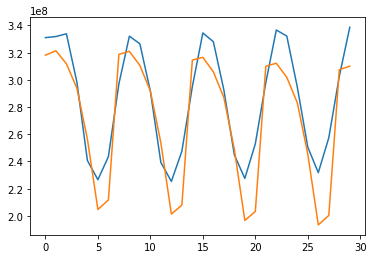

In [160]:
# plt.figure(figsize=(20,8))

plt.plot(df['purchase1'])
plt.plot(df['purchase2'])
plt.show()

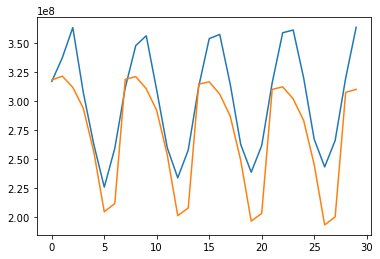

In [161]:
plt.plot(df['redeem1'])
plt.plot(df['redeem2'])
plt.show()

In [162]:
# df['purchase'] = 0.6*df['purchase1'] + 0.4*df['purchase2']
# df['redeem'] = 0.6*df['redeem1'] + 0.4*df['redeem2']

for index, row in df.iterrows():
    df.loc[index, 'purhcase'] = min(row['purchase1'], row['purchase2'])
    df.loc[index, 'redeem'] = min(row['redeem1'], row['redeem2'])
df.head()

,ds,purchase1,redeem1,purchase2,redeem2,purhcase,redeem
0,20140901,331052148.944308,316907458.896058,318187058.519883,318187058.519883,3.181871e+08,3.169075e+08
1,20140902,331877345.777803,337250518.268437,321435093.184782,321435093.184782,3.214351e+08,3.214351e+08
2,20140903,333891801.463518,363246860.209706,311869183.692426,311869183.692426,3.118692e+08,3.118692e+08
3,20140904,298318964.067410,307479922.883234,293854961.836403,293854961.836403,2.938550e+08,2.938550e+08
4,20140905,240752229.000847,262807347.846188,256478779.657548,256478779.657548,2.407522e+08,2.564788e+08


In [ ]:
# df[['ds', 'purchase', 'redeem']].to_csv('baseline_stacking.csv', header=None, index=False)

## => Model stacking: online score = 101.5570

# 4. Ultilising Weekly & Monthly Pattern

基于周期因子的时间序列预测

需要确定周期长度，比如7天（一周），30天（一个月），结合STL分解 (Seasonal and Trend decomposition) 观察周期变化。

以周期=7为例：

- 思路 

用过去的周一去预测未来的周一，过去的周二去预测未来的周二，etc。

- 实现：

周期因子 = 过去每一个星期x的均值/数据整体均值（base）。

此项目是预测下个月每一天的情况（周期=30）：基于每月的规律（1-30号的平均流量）* 周期因子

- 实现步骤：

Step1：计算周期因子（weekday）：每周的平均值/整体平均值

Step2：计算朴素日期因子（month-day）：
  - 统计星期x（weekday）在每日（month_day）出现的频次   --->   作为weekday对month_day的影响
  - 计算每日的base：每日的所有[频次\*周期因子]之和/总共的月份 --->  作为month_day基于周期因子获得的加权均值
  - 计算日期因子：每日（1号-30号）均值/每日对应的base --->  除以每日的base作用是去掉周期因子对当天的影响

Step3：朴素日期因子\*周期因子为最终预测值



In [123]:
with open('./data/purchase.pkl', 'rb') as file:
    purchase = pickle.load(file)

with open('./data/redeem.pkl', 'rb') as file:
    redeem = pickle.load(file)

purchase = purchase.reset_index()
redeem = redeem.reset_index()
purchase.head()

,report_date,total_purchase_amt
0,2013-07-01,32488348
1,2013-07-02,29037390
2,2013-07-03,27270770
3,2013-07-04,18321185
4,2013-07-05,11648749


In [124]:
redeem['day'] = redeem['report_date'].dt.day
redeem['weekday'] = redeem['report_date'].dt.weekday

purchase['day'] = purchase['report_date'].dt.day
purchase['weekday'] = purchase['report_date'].dt.weekday

purchase.head()
# 在weekday中，0=周一，6=周日

,report_date,total_purchase_amt,day,weekday
0,2013-07-01,32488348,1,0
1,2013-07-02,29037390,2,1
2,2013-07-03,27270770,3,2
3,2013-07-04,18321185,4,3
4,2013-07-05,11648749,5,4


<AxesSubplot:xlabel='weekday'>

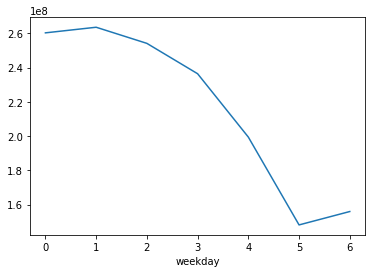

In [125]:
purchase.groupby(['weekday'])['total_purchase_amt'].mean().plot()

### Thought:

这种weekly pattern可能受收益计算方式影响。资金存入，一般两日后显示收益。e.g. 周一存入，周三显示收益。但周五、周六、周日的收益显示时间例外。周五到下周二，周六/天到下周三。

## use data after 2014-04-01 because the trend gets stable after that

In [127]:
purchase2 = purchase[purchase['report_date']>='2014-04-01']
redeem2 = redeem[redeem['report_date']>='2014-04-01']

total_df = purchase2.merge(redeem2, on=['report_date', 'day', 'weekday'], how='left')
total_df.head()

,report_date,total_purchase_amt,day,weekday,total_redeem_amt
0,2014-04-01,453320585,1,1,277429358
1,2014-04-02,355347118,2,2,272612066
2,2014-04-03,363877120,3,3,266605457
3,2014-04-04,251895894,4,4,200192637
4,2014-04-05,202336542,5,5,163199682


## 计算周期因子（weekday） = 每周的平均值/整体平均值

In [130]:
weekday_weight = total_df.groupby(['weekday'])['total_purchase_amt', 'total_redeem_amt'].mean().reset_index()

weekday_weight['purchase_weekday'] = weekday_weight['total_purchase_amt']/purchase2.mean()['total_purchase_amt']
weekday_weight['redeem_weekday'] = weekday_weight['total_redeem_amt']/redeem2.mean()['total_redeem_amt']


weekday_weight

,weekday,total_purchase_amt,total_redeem_amt,purchase_weekday,redeem_weekday
0,0,3.075183e+08,3.268733e+08,1.163446,1.226999
1,1,3.173125e+08,3.138971e+08,1.200501,1.178289
2,2,3.133103e+08,3.076354e+08,1.185360,1.154784
3,3,3.019386e+08,2.763898e+08,1.142336,1.037496
4,4,2.398712e+08,2.591565e+08,0.907514,0.972807
5,5,1.837682e+08,1.855464e+08,0.695258,0.696494
6,6,1.884616e+08,1.980553e+08,0.713014,0.743449


In [131]:
total_df = pd.merge(total_df, weekday_weight[['weekday', 'purchase_weekday', 'redeem_weekday']], \
                    on='weekday', how='left')
total_df.head()

,report_date,total_purchase_amt,day,weekday,total_redeem_amt,purchase_weekday,redeem_weekday
0,2014-04-01,453320585,1,1,277429358,1.200501,1.178289
1,2014-04-02,355347118,2,2,272612066,1.185360,1.154784
2,2014-04-03,363877120,3,3,266605457,1.142336,1.037496
3,2014-04-04,251895894,4,4,200192637,0.907514,0.972807
4,2014-04-05,202336542,5,5,163199682,0.695258,0.696494


## 计算日期因子（month_day）

In [138]:
# 统计周一到周日('weekday')分别在1～31号('day')中出现的频次，显示在report_date一栏

weekday_count = total_df.groupby(['weekday', 'day'])[['report_date']].count().reset_index()
weekday_count = pd.merge(weekday_count, weekday_weight, on='weekday')
weekday_count

,weekday,day,report_date,total_purchase_amt,total_redeem_amt,purchase_weekday,redeem_weekday
0,0,2,1,3.075183e+08,3.268733e+08,1.163446,1.226999
1,0,4,1,3.075183e+08,3.268733e+08,1.163446,1.226999
2,0,5,1,3.075183e+08,3.268733e+08,1.163446,1.226999
3,0,7,2,3.075183e+08,3.268733e+08,1.163446,1.226999
4,0,9,1,3.075183e+08,3.268733e+08,1.163446,1.226999
...,...,...,...,...,...,...,...
118,6,24,1,1.884616e+08,1.980553e+08,0.713014,0.743449
119,6,25,1,1.884616e+08,1.980553e+08,0.713014,0.743449
120,6,27,2,1.884616e+08,1.980553e+08,0.713014,0.743449
121,6,29,1,1.884616e+08,1.980553e+08,0.713014,0.743449


In [139]:
# 周期因子 * 周一到周日('weekday')在1～31号('day')中出现的频次 / 一共多少个月
# 频次：用于计算weekday周期因子对month_day贡献了多少次

weekday_count['purchase_weekday'] = weekday_count['purchase_weekday'] * weekday_count['report_date'] / total_df['report_date'].dt.month.nunique()
weekday_count['redeem_weekday'] = weekday_count['redeem_weekday'] * weekday_count['report_date'] / total_df['report_date'].dt.month.nunique()

weekday_count


,weekday,day,report_date,total_purchase_amt,total_redeem_amt,purchase_weekday,redeem_weekday
0,0,2,1,3.075183e+08,3.268733e+08,0.232689,0.245400
1,0,4,1,3.075183e+08,3.268733e+08,0.232689,0.245400
2,0,5,1,3.075183e+08,3.268733e+08,0.232689,0.245400
3,0,7,2,3.075183e+08,3.268733e+08,0.465378,0.490799
4,0,9,1,3.075183e+08,3.268733e+08,0.232689,0.245400
...,...,...,...,...,...,...,...
118,6,24,1,1.884616e+08,1.980553e+08,0.142603,0.148690
119,6,25,1,1.884616e+08,1.980553e+08,0.142603,0.148690
120,6,27,2,1.884616e+08,1.980553e+08,0.285206,0.297380
121,6,29,1,1.884616e+08,1.980553e+08,0.142603,0.148690


In [144]:
# 计算weekday对平均每月（因为之前除以了月份个数）中的month_day的影响力：即month_day基于weekday因子获得加权均值

day_rate = weekday_count.groupby(['day'])[['purchase_weekday', 'redeem_weekday']].sum().reset_index()
day_rate

,day,purchase_weekday,redeem_weekday
0,1,1.032773,1.022066
1,2,1.027387,1.041174
2,3,0.978689,0.938645
3,4,0.975370,1.014169
4,5,0.979360,0.967154
5,6,0.943881,0.958556
6,7,1.069969,1.068554
7,8,1.032773,1.022066
8,9,1.027387,1.041174
9,10,0.978689,0.938645


In [147]:
# 特殊处理31号，因为5个月中出现了31号的只有3次：5月31日，7月31日，8月31日

day_rate.loc[30,'purchase_weekday'] *= 5/3
day_rate.loc[30,'redeem_weekday'] *= 5/3
day_rate.loc[30]

day                 31.000000
purchase_weekday     0.850203
redeem_weekday       0.825813
Name: 30, dtype: float64

In [143]:
# 按照日期（day）计算1号均值，2号均值...

day_mean = total_df.groupby(['day'])[['total_purchase_amt', 'total_redeem_amt']].mean().reset_index()
day_mean

,day,total_purchase_amt,total_redeem_amt
0,1,3.178338e+08,2.394654e+08
1,2,2.425101e+08,2.130890e+08
2,3,2.583158e+08,2.535862e+08
3,4,2.743470e+08,3.009591e+08
4,5,3.034936e+08,2.644835e+08
5,6,2.474568e+08,2.466850e+08
6,7,2.643790e+08,2.267630e+08
7,8,3.015848e+08,2.689660e+08
8,9,2.938419e+08,2.515698e+08
9,10,3.140940e+08,2.496543e+08


In [146]:
# 计算一个朴素的month_day日期因子（朴素：不带有weekday周期因子的影响）

day_base = pd.merge(day_mean, day_rate, on='day', how='left')


# 周期因子是每周某星期的平均数/整体平均数，整体平均数起到归一化的作用
# 周期因子代表每周某星期的申购或赎回相当于申购或赎回的整体平均数的倍数关系
# 原total_purchase_amt是每月某号的申购的平均数，是带有周期因子作用的平均数
# 原total_purchase_amt/purhcase_weekday是算每月某号的申购平均数相当于该号对于（周期因子加权平均*申购整体平均数之乘积）的倍数
# 目的是为了去除掉周期因子加权的影响，算单纯的日期对于整体平均数的影响
day_base['total_purchase_amt'] = day_base['total_purchase_amt'] / day_base['purchase_weekday']
day_base['total_redeem_amt'] = day_base['total_redeem_amt'] / day_base['redeem_weekday']

day_base

,day,total_purchase_amt,total_redeem_amt,purchase_weekday,redeem_weekday
0,1,3.077478e+08,2.342954e+08,1.032773,1.022066
1,2,2.360455e+08,2.046623e+08,1.027387,1.041174
2,3,2.639406e+08,2.701620e+08,0.978689,0.938645
3,4,2.812749e+08,2.967544e+08,0.975370,1.014169
4,5,3.098898e+08,2.734657e+08,0.979360,0.967154
5,6,2.621696e+08,2.573507e+08,0.943881,0.958556
6,7,2.470903e+08,2.122148e+08,1.069969,1.068554
7,8,2.920145e+08,2.631591e+08,1.032773,1.022066
8,9,2.860088e+08,2.416214e+08,1.027387,1.041174
9,10,3.209334e+08,2.659731e+08,0.978689,0.938645


In [163]:
# day_base['total_purchase_amt'] 
import datetime

start = datetime.datetime(2014,9,1)
end  = datetime.datetime(2014,9,30)

testdata = []
for x in pd.date_range(start, end):
    temp = [x, np.nan, np.nan]
    testdata.append(temp)
    
testdata = pd.DataFrame(testdata, columns=['report_date', 'purchase', 'redeem'])
testdata['day'] = testdata['report_date'].dt.day
testdata['weekday'] = testdata['report_date'].dt.weekday
testdata.head()

,report_date,purchase,redeem,day,weekday
0,2014-09-01,NaN,NaN,1,0
1,2014-09-02,NaN,NaN,2,1
2,2014-09-03,NaN,NaN,3,2
3,2014-09-04,NaN,NaN,4,3
4,2014-09-05,NaN,NaN,5,4


In [166]:
for index, row in testdata.iterrows():
    # 找到每月某号的朴素日期因子（作为base）
    base = day_base[day_base['day'] == row['day']]['total_purchase_amt'].iloc[0]
    # 找到该号对应的周期因子
    weekday_factor = weekday_weight[weekday_weight['weekday'] == row['weekday']]['purchase_weekday'].iloc[0]
    # 使用 base * weekday factor （叠加日期和周期双重影响）作为预测值
    testdata.loc[index, 'purchase'] = base * weekday_factor
    
    base = day_base[day_base['day'] == row['day']]['total_redeem_amt'].iloc[0]
    weekday_factor = weekday_weight[weekday_weight['weekday'] == row['weekday']]['redeem_weekday'].iloc[0]
    testdata.loc[index, 'redeem'] = base * weekday_factor

testdata['report_date'] = testdata['report_date'].apply(lambda x: str(x).replace('-','')[0:8])
testdata.head()

,report_date,purchase,redeem,day,weekday
0,20140901,3.580481e+08,2.874801e+08,1,0
1,20140902,2.833728e+08,2.411514e+08,2,1
2,20140903,3.128646e+08,3.119789e+08,3,2
3,20140904,3.213105e+08,3.078816e+08,4,3
4,20140905,2.812294e+08,2.660293e+08,5,4


In [ ]:
# testdata[['report_date', 'purchase', 'redeem']].to_csv('baseline_weekday.csv', header=None, index=False)

## => Ultilising Weekly & Monthly Pattern: online score = 118.1111

# Exploratory Data Analysis